0.925
0.925
|--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



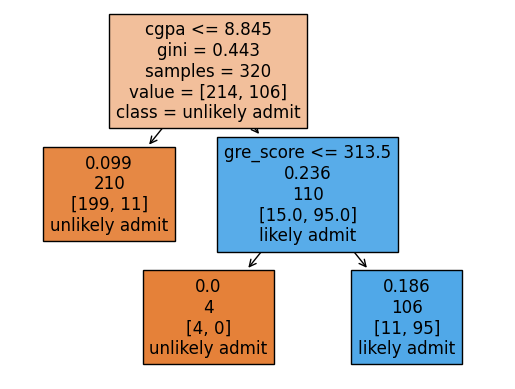

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import tree


df = pd.read_csv("Admission_Predict.csv")
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

#create a new column called chance_of_admit that is True if chance_of_admit is greater than or equal to 0.8 and False otherwise
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']>=.8

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01,criterion='gini')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))
print(accuracy_score(y_test, y_pred))

#visualize the tree
tree.plot_tree(dt, feature_names = x_train.columns,  
               max_depth=3, class_names = ['unlikely admit', 'likely admit'],
               label='root', filled=True)
print(tree.export_text(dt, feature_names = X.columns.tolist()))

In [53]:
#calculate the gini impurity of the root node
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)
   
gi = gini(y_train)
print(f'Gini impurity at root: {round(gi,3)}')

#calculate the information gain
def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)
info_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    info_gain_list.append([i, info_gain(left, right, gi)])

ig_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
ig_table.head(10)



Gini impurity at root: 0.443


,split_value,info_gain
10,8.84,0.296932
124,8.85,0.291464
139,8.88,0.290704
18,8.90,0.290054
98,8.83,0.287810
110,8.87,0.286050
152,8.94,0.284714
57,8.96,0.284210
96,8.80,0.283371
21,9.00,0.283364


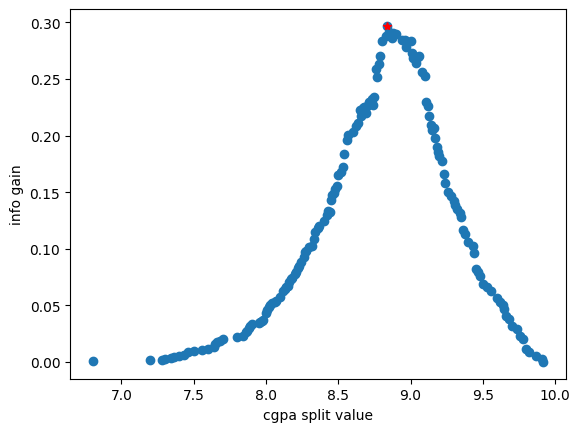

In [54]:
# plot the information gain
plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0], ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')
plt.show()
plt.close()

In [55]:
# regresion variables
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeRegressor(max_depth=3, ccp_alpha=0.001)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.5230242793515553


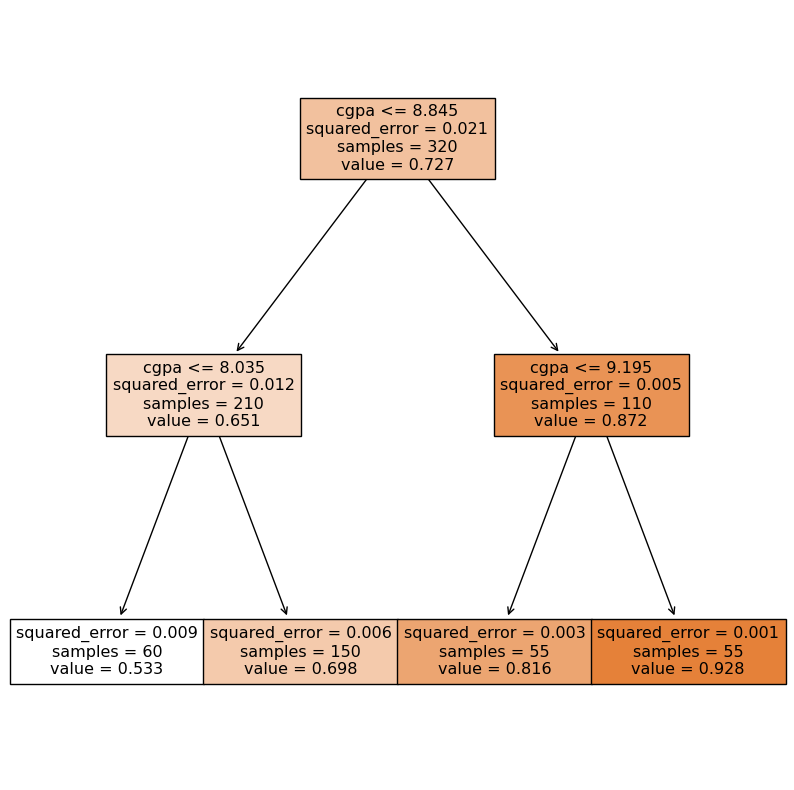

In [56]:
#visualize the tree
plt.figure(figsize=(10,10))
tree.plot_tree(dt, feature_names = x_train.columns,  
               max_depth=2, filled=True);

In [57]:
#define the mean squared error function
def mse(data):
    """Calculate the MSE of a data set
    """
    return np.mean((data - data.mean())**2)
   
def mse_gain(left, right, current_mse):
    """Information Gain (MSE) associated with creating a node/split data based on MSE.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_mse - w * mse(left) - (1 - w) * mse(right)

m = mse(y_train)
print(f'MSE at root: {round(m,3)}')

mse_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    mse_gain_list.append([i, mse_gain(left, right, m)])

mse_table = pd.DataFrame(mse_gain_list,columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(mse_table.head(10))

MSE at root: 0.021
     split_value  info_gain
10          8.84   0.011065
96          8.80   0.011037
98          8.83   0.011023
124         8.85   0.010985
125         8.73   0.010939
110         8.87   0.010932
139         8.88   0.010895
1           8.70   0.010894
17          8.76   0.010858
140         8.74   0.010850


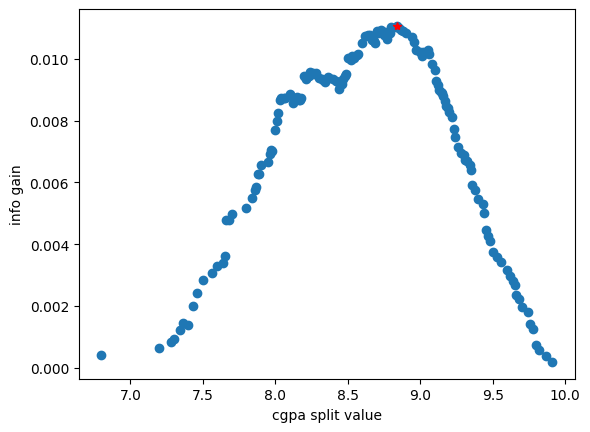

In [58]:
# plot the information gain
plt.plot(mse_table['split_value'], mse_table['info_gain'],'o')
plt.plot(mse_table['split_value'].iloc[0], mse_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')
plt.show()
plt.close()

In [59]:
np.unique(dt.predict(x_train))

array([0.53283333, 0.6976    , 0.81618182, 0.92781818])